# The Problem: Discrimination by Proxy

In [1]:
import json
from DiscriminationMitigation import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 100)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # turn off tensorflow warning messages

In [2]:
# Function to create a Tensorflow Keras deep learning model
def keras_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(32))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(128))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(16))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Function to aggregate a dataframe according to a rounded feature, 'w0'
def aggregate_data(df):
    df = pd.concat([df, synth[['w0']].reset_index(drop=True)], axis=1)
    df['w0'] = round(df['w0'], 1)
    df = df.sort_values(by=['w0'])
    return df.groupby(['w0']).mean()

### Instantiate some synthetic data

In [3]:
def simple_synth(n=8000, class_prob=0.5, gamma=np.matrix([[2,3.5],[.4,.6]]), alpha=np.matrix([[0,2]]), 
                 beta=np.matrix([[2,2],[1,1]])):
    
    np.random.seed(1776)

    # Protected class variable
    c1 = np.random.binomial(1, p=class_prob, size=n) # group 1
    c0 = 1-c1 # group 0

    # Other covariates
    w0 = gamma[0,0]*c0 + gamma[0,1]*c1 + np.random.normal(0, 0.5, size=n) # linear function of class & shock
    w1 = gamma[1,0]*c0 + gamma[1,1]*c1 + np.random.normal(0, 0.3, size=n)
                                                                 
    # Outcome variable
    y = alpha[0,0]*c0   + alpha[0,1]*c1 + beta[0,0]*c0*w0 + beta[0,1]*c1*w0 + beta[1,0]*c0*w1 + beta[1,1]*c1*w1 + \
        np.random.normal(0, 0.3, size=n)

    return pd.DataFrame([y, c0, c1, w0, w1]).T.rename(columns={0:'y', 1: 'c0', 2: 'c1', 3: 'w0', 4:'w1'})

In [4]:
synth = simple_synth()
print(synth.head())
print("\n", synth.shape)

          y   c0   c1        w0        w1
0  4.673528  1.0  0.0  2.214135  0.324108
1  7.939870  0.0  1.0  2.404301  1.070192
2  5.222822  1.0  0.0  2.338783  0.519127
3  9.406248  0.0  1.0  3.145858  0.822292
4  3.990423  1.0  0.0  1.523643  0.897265

 (8000, 5)


We instantiate some synthetic data with a continuous target variable *y*, a binary protected class feature with two dummies for category *c1* and *c0*, and we have covariates *w1* and *w2*.  Protected cass membership is drawn from a binomial distribution. Covariates depend upon independent normal draws plus class category-specific means.  These means generate correlation between class category membership and covariates.  The target variables *y* is determined by covariates, independent normal draws, and class category membership. Class category membership causing y can be thought of many ways. We find it most convenient to interpret it as representing unobserved causal variables that are correlated with protected class, but it could also represent statistical discrimination or taste-based discrimination in the target. 

### Visualizing the problem

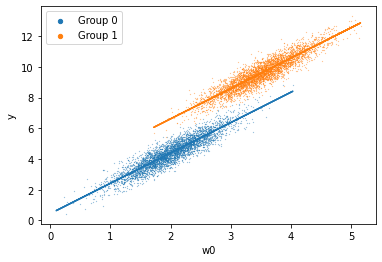

In [5]:
c0_grp = synth.loc[synth["c0"] == 1]
c1_grp = synth.loc[synth["c1"] == 1]

# Estimate fitted values from a linear regression model
c0_pred = LinearRegression().fit(c0_grp[["w0"]], c0_grp["y"]).predict(c0_grp[["w0"]])
c1_pred = LinearRegression().fit(c1_grp[["w0"]], c1_grp["y"]).predict(c1_grp[["w0"]])

# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

*Cullen - I think we need an explanation here. You can potentially use some of the text from above, and shorten that block*

### Remedy 1: The naive approach
#### Exclude all protected class feature(s) from the model

In [57]:
# Train a Tensorflow Keras deep learning model
model = keras_model()
model.fit(synth[['w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
pred = model.predict(synth[['w0']]) # Generate prediction from model

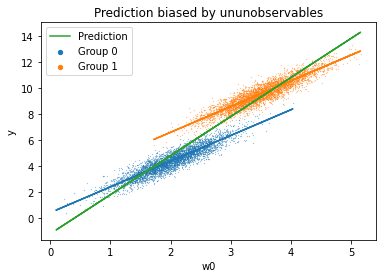

In [58]:
# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(c0_grp["w0"], c0_pred)
plt.plot(c1_grp["w0"], c1_pred)
plt.plot(synth['w0'], pred, label='Prediction')
plt.title('Prediction biased by ununobservables')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

*Cullen - we need to explain the above*

### Remedy 2: Include protected class feature(s) & hope for the best

In [62]:
model = keras_model()
model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)
pred = pd.DataFrame(model.predict(synth[['c0', 'c1', 'w0']]))
pred = aggregate_data(pred)

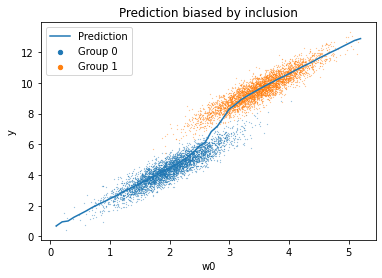

In [56]:
# Scatter & line plot using Matplotlib
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(pred, label='Prediction')
plt.title('Prediction biased by inclusion')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

We need words here

# `DiscriminationMitigator`

*We need an introduction*

### Basic setup

#### Specify a configuration file

In [9]:
with open('example_config.json') as j:
    config = json.load(j)
print("Example configuration dictionary: \n", config)

Example configuration dictionary: 
 {'protected_class_features': ['c0', 'c1']}


The config file requires users specify the protected class feature(s) as a list. Any features estimated in the model but not included in this list are assumed to be non-protected classe features.

#### Take a pre-trained LightGBM or Tensorflow Keras model (sequential/model)
*NOTE: PROTECTED CLASS FEATURE(S) MUST BE INCLUDED IN THE TRAINING MODEL!!*

In [102]:
# Note - we estimate the same model as directly above for clarity
model = keras_model()
model.fit(synth[['c0', 'c1', 'w0']], synth['y'], epochs=60, batch_size=128, verbose=0)

#### Instantiate `DiscriminationMitigator` class & call `predictions()` method

In [10]:
mitigated = DiscriminationMitigator(df=synth[['c0', 'c1', 'w0']], model=model, 
                              config=config).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

   unadj_pred  unif_wts
0    4.965948  6.103953
1    7.616042  6.478035
2    5.211146  6.349152
3    9.074779  7.936771
4    3.607662  4.745668

         unadj_pred     unif_wts
count  8000.000000  8000.000000
mean      7.152867     7.157703
std       2.792188     1.770927
min       0.809666     1.947672
25%       4.527180     5.662278
50%       7.012392     7.135668
75%       9.776754     8.643230
max      13.026226    11.888220


The default specification returns a Pandas DataFrame with two features: `unadj_pred`, which is the unadjusted (biased) prediction, and `unif_wts`, which is the average of counterfactual predictions (i.e. uniform weights)

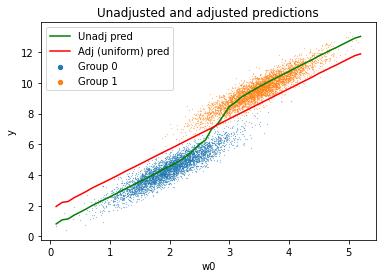

In [11]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unadj_pred'], label='Unadj pred', color='green')
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.title('Unadjusted and adjusted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

### Option 1: Reweight predictions using the joint distributions of another dataset

In [12]:
# Split the data into train/val and test sets
X_train, X_test, y_train, y_test = train_test_split(synth.loc[:, ['c0', 'c1', 'w0']],
                                                    synth['y'], random_state=1776,
                                                    test_size=0.2)
# Train / val split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=123, 
                                                  test_size=0.2)

for x in X_train, X_val, X_test:
    print(x.shape)

(5120, 3)
(1280, 3)
(1600, 3)


In [13]:
# Reestimate the model
model = keras_model()
model.fit(X_train, y_train, epochs=60, batch_size=128, validation_data=(X_val, y_val), verbose=0)

In [15]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train).predictions()

print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts
6899    9.485124  8.373460  8.363038
163    10.260772  9.149107  9.138685
4780    9.698990  8.587325  8.576903
1891    5.479504  6.591168  6.580746
5372    7.873767  6.762103  6.751680

         unadj_pred     unif_wts      pop_wts
count  1600.000000  1600.000000  1600.000000
mean      6.971320     7.004671     6.994248
std       2.771893     1.770655     1.770655
min       1.360163     2.471827     2.461406
25%       4.355868     5.467532     5.457111
50%       6.281881     6.908367     6.897945
75%       9.641458     8.529793     8.519371
max      12.808136    11.696472    11.686050


Optionally, `DiscriminationMitigator` allows users to reweight predictions to reflect the joint distributions of the protected class feature(s) in another dataset. This may be advantageous, for example, if your test set is considerably smaller than your training set. In this case, `unif_wts` reflects the joint distributions of `df` (i.e. uniform weights; the default), while `pop_wts` reflects the joint distributions of `train`.

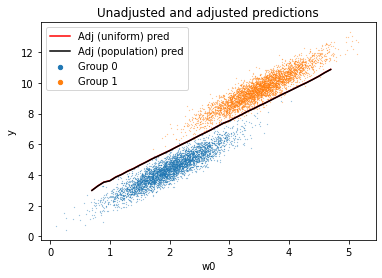

In [16]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.title('Unadjusted and adjusted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()

### Option 2: Custom reweighting of select feature marginal distributions

In [17]:
with open('example_weights.json') as j:
    weights = json.load(j)
print(weights)

{'c0': {'1': 0.9, '0': 0.1}, 'c1': {'1': 0.1, '0': 0.9}}


You may also want to reweight predictions to ask 'what-if' questions: i.e. what if the share of group *x* were different than their observed share in the data? Providing a dictionary of custom marginal distributions to `weights` will allow for this. Importantly, feature marginals must sum to 1.0, otherwise this will produce a ValueError. At present it is only possible to reweight the marginal distributions of select features, not their joint distributions.

In [20]:
mitigated = DiscriminationMitigator(df=X_test, model=model, 
                              config=config, train=X_train, weights=weights).predictions()
print(mitigated.head())
print("\n", mitigated.describe())

      unadj_pred  unif_wts   pop_wts  cust_wts
6899    9.485124  8.373460  8.363038  7.484128
163    10.260772  9.149107  9.138685  8.259776
4780    9.698990  8.587325  8.576903  7.697994
1891    5.479504  6.591168  6.580746  5.701836
5372    7.873767  6.762103  6.751680  5.872771

         unadj_pred     unif_wts      pop_wts     cust_wts
count  1600.000000  1600.000000  1600.000000  1600.000000
mean      6.971320     7.004671     6.994248     6.115339
std       2.771893     1.770655     1.770655     1.770655
min       1.360163     2.471827     2.461406     1.582496
25%       4.355868     5.467532     5.457111     4.578201
50%       6.281881     6.908367     6.897945     6.019035
75%       9.641458     8.529793     8.519371     7.640461
max      12.808136    11.696472    11.686050    10.807142



Warning! The following features are extremely correlated and thus may be one-hot vectors: c0 c1. 
If no category is omitted, users must ensure custom marginal weights for one-hot vectors align correctly.


Moreover, in the presence of custom weights, `DiscriminationMitigator` raises a warning if any features appear extremely correlated, suggesting they may be recripocal one-hot vectors and that custom weights should therefore reflect mutual exclusivity in the underlying data. In our case, the joint distributions protected class features `c0` and `c1` are polar opposites, meaning we need to reweight *both* of these features. `DiscriminationMitigator`, however, does not enforce that custom weights of adjacent one-hot vectors are in fact reciprocals. 

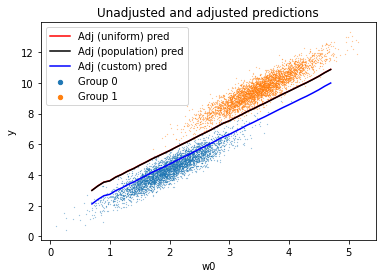

In [22]:
avg = aggregate_data(mitigated) # Average by rounded 'w0'
plt.scatter(c0_grp["w0"], c0_grp["y"], label='Group 0', s=0.03)
plt.scatter(c1_grp["w0"], c1_grp["y"], label='Group 1', s=0.03)
plt.plot(avg['unif_wts'], label='Adj (uniform) pred', color='red')
plt.plot(avg['pop_wts'], label='Adj (population) pred', color='black')
plt.plot(avg['cust_wts'], label='Adj (custom) pred', color='blue')
plt.title('Unadjusted and adjusted predictions')
plt.xlabel('w0')
plt.ylabel('y')
plt.legend(markerscale=25)
plt.show()